<a href="https://colab.research.google.com/github/aleks-haksly/Postypashka/blob/main/DA/02%20HW_lab/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint
from tqdm.notebook import tqdm
import json

# Подготовка данных для анализа

1. Скачаем реестр анализируемых компаний
2. Прочитаем Excel файл и создадим из него DataFrame. Считывать будем только колонки, которые будут использоваться в дальнейших расчетах показателя
[EBITDA](https://xn--80aapampemcchfmo7a3c9ehj.xn--p1ai/news/chto-takoe-ebitda/)


In [7]:
# файл Реестр.xlsx для обработки
!wget "https://github.com/aleks-haksly/Postypashka/raw/refs/heads/main/DA/02%20HW_lab/%D0%A0%D0%B5%D0%B5%D1%81%D1%82%D1%80.xlsx" -q
# файл reestr_filtered.xlsx - результат обработки при подготовке данных
!wget "https://github.com/aleks-haksly/Postypashka/raw/main/DA/02%20HW_lab/reestr_filtered.xlsx" -q

In [14]:
df_reestr = pd.read_excel("/content/Реестр.xlsx", header = 2, usecols=[1, 2, 3, 5, 6, 7, 9]) # nrows=1000

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [15]:
df_reestr.head(5)

,Наименование / ФИО,Тип субъекта,Категория,ИНН,Основной вид деятельности,Регион,Город
0,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN
1,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN
2,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,5263039399,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,г Нижний Новгород
3,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,5263025484,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,г Нижний Новгород
4,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,7801123215,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN


3. Отфильтруем DataFrame и сохраним его копию, содержащую данные отвечающие всем условиям:
* Юридическое лицо
* Среднее предприятие либо Малое предприятие
* Основной вид деятельности - "41.20 Строительство жилых и нежилых зданий"

In [16]:
df_reestr = df_reestr.query("(`Категория` in ('Среднее предприятие', 'Малое предприятие')) & \
                             (`Основной вид деятельности` == '41.20 Строительство жилых и нежилых зданий') &\
                             (`Тип субъекта` == 'Юридическое лицо')")[['Наименование / ФИО', 'Регион', 'Город', 'Категория', 'ИНН']]

In [17]:
df_reestr.to_excel("reestr_filtered.xlsx", index=False)

# Парсинг данных

Парсинг будет состоять из 2 этапов:
1. Для кажого предприятия, находящегося в нашем DataFrame мы по ИНН получим его внутренний `id` сайта nalog.ru
2. Используя найденные `id` мы выгрузим и аггрегируем ифнормацию об изменени **EBITDA** компаний во времени

## Этап 1 - получения внтренних id компаний

In [22]:
df_reestr = pd.read_excel("reestr_filtered.xlsx", index_col=[0])
df_reestr.head()

,Наименование / ФИО,Регион,Город,Категория,ИНН
19,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838
51,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369
4652,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922
4667,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",33 - Владимирская область,г Владимир,Малое предприятие,3327332190
4673,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",78 - г.Санкт-Петербург,NaN,Малое предприятие,7816061297


In [23]:
# сохраним все ИНН в список
inns = df_reestr['ИНН'].to_list()

In [24]:
# для парсинг будем использовать cсессию с заголовком, маскирующим нас под браузер
session = requests.Session()

headers ={'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.28 Safari/537.36'}

session.headers = headers
session.timeo0ut = 6

In [25]:
# напишем функцию для парсинга id компаний по их ИНН
def inn_to_id(inn:str, session:requests.Session=session)->str:
    try:
        response = session.get(f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0")
        if response.status_code == 200:
            content = response.json().get("content", None)
            if isinstance(content, list):
                id = content[0].get('id', None)
                if not id:
                    print(f"По ИНН {inn} данные не найдены.")
                return (inn, id)
            return (inn, None)
        else:
            print(f"Ошибка запроса: {response.status_code}")
            return (None, None)
    except requests.exceptions.RequestException as e:
        print(f"Ошибка соединения: {e}")
        return (None, None)

In [ ]:
# создадим файл, куда будем сохранять результаты парсинга id
with open('company_ids.json', 'w') as file:
    json.dump([['inn', 'id']], file)

In [ ]:
# основной цикл 1 части программы - парсим и сохраняем (ИНН, id) организаций в файл company_ids.json
s = 60 # таймаут в случае, если сервер сбрасывает подключение
while len(inns) > 0: #пока остались необработанные ИНН
    ids = json.load(open('company_ids.json', 'r'))
    inns = set(inns) - set(id[0] for id in ids) # убираем из множества ИНН те, для которых уже получен id
    print(f"Осталось обработать {len(inns)} ИНН")
    for inn in tqdm(inns):
        sleep(0.5)
        id = inn_to_id(inn, session)
        if not any(id): # если была ошибка подключения или сервер не вернул данные как следует
            # для сериализации данных по ИНН - id и сохранению в файл
            with open('company_ids.json', 'w') as file:
                json.dump(ids, file)
            print(f'Жду {s} секунд и пробую продолжить')
            sleep(s)
            break
        ids.append(id)

with open('company_ids.json', 'w') as file:
                json.dump(ids, file)

## Этап 2 - получение данных о финансовых показателях компаний

Коды строк в формах бухгалтерской отчетности, указываемые в годовой бухгалтерской отчетности организации, представляемой в органы государственной статистики и другие органы исполнительной власти
1. Чистая прибыль (убыток) 2400
  
2. Налог на прибыль 2410
  
3. Проценты по долговым обязательствам  2330
  
4. Амортизация 1210 (1190)

6. Выручка 2110

In [29]:
# файл company_ids.json - результат парсинга этапа 1
!wget "https://raw.githubusercontent.com/aleks-haksly/Postypashka/refs/heads/main/DA/02%20HW_lab/company_ids.json" -q

In [26]:
# функция для преобразование строк в float
def str_to_float(s: str) -> float:
    try:
        return float(s)
    except (TypeError, ValueError):
        return 0

In [27]:
# напишем функцию для парсинга финансовых показателей и расчета EBITDA
def ebitda_calc(id:str, session:requests.Session=session, revenue_year=2023):
    EBITDA = {'id': id}
    try:
        response = session.get(f"https://bo.nalog.ru/nbo/organizations/{id}/bfo")
        if response.status_code == 200:
            for year_data in response.json():
                year = year_data.get('period', None)
                financialResult = year_data.get('correction', dict()).get('financialResult', None)
                balance = year_data.get('correction', dict()).get('balance', None)
                if isinstance(financialResult, dict) and isinstance(balance, dict):
                    profit = financialResult.get('current2400', None)
                    taxes = financialResult.get('current2410', None)
                    interest = financialResult.get('current2330', None)
                    depreciation = balance.get('current1210', None)
                    revenue = financialResult.get('current2110', None)
                #if all([year, profit, taxes, interest, depreciation]):
                try:
                    EBITDA.update({year: sum(map(str_to_float, [profit, taxes, interest, depreciation]))})
                except TypeError:
                    EBITDA.update({year: None})
                if year == str(revenue_year):
                    EBITDA.update({'revenue': revenue})

        else:
            print(f"Ошибка запроса: {response.status_code}")
            return dict()
        return EBITDA
    except requests.exceptions.RequestException as e:
        print(f"Ошибка соединения: {e}")
        return dict()

In [ ]:
# создадим файл EBITDA.json, куда будем сохранять данные о финансовых показателях компаний
with open('EBITDA.json', 'w') as file:
    json.dump([{}], file)

In [30]:
# получим список всех id компаний
ids = set(data[1] for data in json.load(open('company_ids.json', 'r')))

In [ ]:
# основной цикл 2 частипрограммы, где мы получаем данные о финансовых показателях и сохраняем в файл EBITDA.json
s = 60 # таймаут в случае, если сервер сбрасывает подключение
while len(ids) > 0: #пока остались необработанные id
    EBITDA = json.load(open('EBITDA.json', 'r'))
    ids = ids - set(EBITDA.get('id', None) for EBITDA in EBITDA) # убираем из множества id те, для которых уже получена EBITDA
    print(f"Осталось обработать {len(ids)} id")
    for id in tqdm(ids):
        sleep(0.5)
        EBITDA_data = ebitda_calc(id, session)
        if not EBITDA_data.get('id', None): # если была ошибка подключения или сервер не вернул данные как следует
            # для сериализации данных и сохранению в файл
            with open('EBITDA.json', 'w') as file:
                json.dump(EBITDA, file)
            print(f'Жду {s} секунд и пробую продолжить')
            sleep(s)
            break
        EBITDA.append(EBITDA_data)
    with open('EBITDA.json', 'w') as file:
        json.dump(EBITDA, file)


In [ ]:
with open('EBITDA.json', 'w') as file:
        json.dump(EBITDA, file)

# Анализ данных

In [31]:
# файл EBITDA.json - результат парсинга этапа 2
!wget "https://raw.githubusercontent.com/aleks-haksly/Postypashka/refs/heads/main/DA/02%20HW_lab/EBITDA.json" -q

Превратим полученные данные в DataFrame

In [47]:
 df_ebitda = pd.DataFrame.from_records(json.load(open('EBITDA.json', 'r'))[1:])[['id', 'revenue', '2019', '2020', '2021', '2022', '2023']]
 df_ebitda.head(3)

,id,revenue,2019,2020,2021,2022,2023
0,8617989,241709.0,28618.0,33923.0,53279.0,23265.0,30588.0
1,6225927,8014.0,4084.0,745.0,338.0,546.0,465.0
2,3964947,85448.0,11375.0,23754.0,54565.0,20211.0,23332.0


In [48]:
df_reestr = pd.read_excel("reestr_filtered.xlsx" )
df_reestr.head(3)

,Наименование / ФИО,Регион,Город,Категория,ИНН
0,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838
1,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922


In [49]:
ids = json.load(open('company_ids.json', 'r'))
df_ids = pd.DataFrame(ids, columns=['ИНН', 'id']).dropna().astype({"ИНН": "Int64", "id": "Int64"})
df_ids.head(3)

,ИНН,id
0,5038038838,5872486
1,5027006369,6900709
2,1414006922,4980670


Финальный DataFrame содержащий данные о показателе EBITDA по годам для каждого предприятия:

In [53]:
#объединим данные в одну таблицу
data = df_reestr.merge(df_ids, how='left', on='ИНН')\
                .merge(df_ebitda, how='left', on='id')
data.head(5)

,Наименование / ФИО,Регион,Город,Категория,ИНН,id,revenue,2019,2020,2021,2022,2023
0,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838,5872486,108966.0,598067.0,324491.0,253774.0,227785.0,184000.0
1,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369,6900709,1565001.0,98555.0,242052.0,170427.0,194676.0,573989.0
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922,4980670,NaN,NaN,NaN,NaN,NaN,NaN
3,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",33 - Владимирская область,г Владимир,Малое предприятие,3327332190,3867230,1031417.0,77523.0,85031.0,55620.0,65146.0,112194.0
4,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",78 - г.Санкт-Петербург,NaN,Малое предприятие,7816061297,7041303,116186.0,36732.0,35867.0,4333.0,5725.0,20649.0


In [80]:
def replace_extreme_quantiles(col):
    # Calculate the 0.01 and 0.99 quantiles for the column
    quantile_01 = col.quantile(0.01)
    quantile_99 = col.quantile(0.99)
    # Replace values less than the 0.01 quantile with the 0.01 quantile value
    # Replace values greater than the 0.99 quantile with the 0.99 quantile value
    return col.apply(lambda x: quantile_01 if x < quantile_01 else (quantile_99 if x > quantile_99 else x))

<ipython-input-82-e318c4bbe0ab>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\


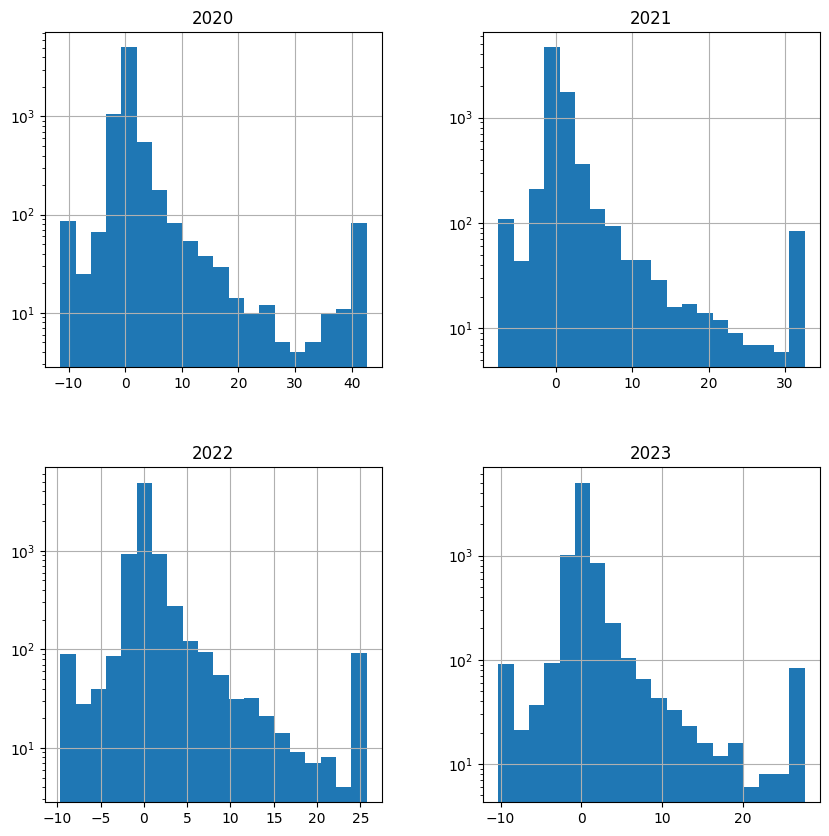

In [82]:
data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\
                                              .pct_change(axis=1)\
                                              .replace([np.inf, -np.inf], np.nan)[['2020', '2021',	'2022',	'2023']]\
                                              .apply(replace_extreme_quantiles, axis=0)\
                                              .hist(bins=20, figsize=(10, 10), log=True);


<ipython-input-85-eb9a2bd796f0>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\


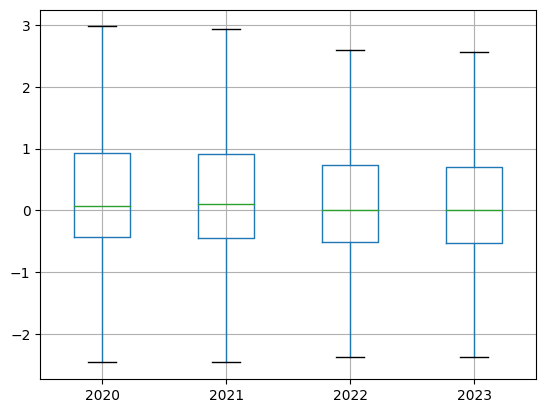

In [85]:
data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\
                                              .pct_change(axis=1)\
                                              .replace([np.inf, -np.inf], np.nan)[['2020', '2021',	'2022',	'2023']]\
                                              .apply(replace_extreme_quantiles, axis=0)\
                                              .boxplot(showfliers=False);

In [ ]:
CONF_LVL = 0.95

def bootstrap_ab(s1, s2, n_trials=5_000, statistic=np.median):
    rng = np.random.default_rng()
    stat_distrib = []

    for _ in range(n_trials):
        boot_s1 = rng.choice(s1, len(s1))
        boot_s2 = rng.choice(s2, len(s2))
        stat_distrib.append(statistic(boot_s1) - statistic(boot_s2))

    result = do_some_math(stat_distrib)
    do_some_viz(result[1], stat_distrib)
    return result

def do_some_math(data):
    # confidence interval counting
    left_q = (1 - CONF_LVL) / 2
    right_q = 1 - left_q
    ci = np.quantile(data, [left_q, right_q])

    # p_value
    quant = stats.norm.cdf(x=0, loc=np.mean(data), scale=np.std(data, ddof=1))
    p_value = quant * 2 if 0 < np.mean(data) else (1 - quant) * 2
    return p_value, ci

p_value, ci = bootstrap_ab(spendings_t, spendings_c)

In [86]:
from scipy.stats import mannwhitneyu

In [87]:
test_data = data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\
                                              .pct_change(axis=1)\
                                              .replace([np.inf, -np.inf], np.nan)[['2020', '2021',	'2022',	'2023']]

<ipython-input-87-303c909a99e4>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_data = data[['2019',	'2020',	'2021',	'2022',	'2023']].dropna(subset=['2021',	'2022',	'2023'])\


In [117]:
alpha = 0.005
for start_year, end_year in zip(test_data.columns[:-1], test_data.columns[1:]):
    print(f'Статистически значимая разница на уровне значимости {alpha:.1%} между {start_year} и {end_year} годами',
     ['обнаружена', 'не обнаружена'][bool(mannwhitneyu(test_data[start_year].dropna(), test_data[end_year].dropna())[1] > alpha)])

Статистически значимая разница на уровне значимости 0.5% между 2020 и 2021 годами не обнаружена
Статистически значимая разница на уровне значимости 0.5% между 2021 и 2022 годами обнаружена
Статистически значимая разница на уровне значимости 0.5% между 2022 и 2023 годами не обнаружена


In [93]:
print('2020 -> 2021 ', mannwhitneyu(test_data['2020'].dropna(), test_data['2021'].dropna()))
print(mannwhitneyu(test_data['2021'].dropna(), test_data['2022'].dropna()))
print(mannwhitneyu(test_data['2022'].dropna(), test_data['2023'].dropna()))

<class 'pandas.core.frame.DataFrame'>
Index: 7810 entries, 0 to 8926
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2020    7363 non-null   float64
 1   2021    7599 non-null   float64
 2   2022    7768 non-null   float64
 3   2023    7753 non-null   float64
dtypes: float64(4)
memory usage: 305.1 KB


True

'Не обнаружено'